In [ ]:
from dataclasses import dataclass
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from pathlib import Path


In [2]:
sns.set_theme(style="whitegrid")

ASSIGNMENT_PATH = Path().resolve().parent
DATA_PATH = ASSIGNMENT_PATH / "data"
OUTPUT_PATH = ASSIGNMENT_PATH / "output"
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
EXPORT_DPI = 600
assert DATA_PATH.exists()

In [3]:
@dataclass
class ModelParams:
    p: int
    d: int
    q: int
    P: int
    D: int
    Q: int
    s: int

    phis: list[float]
    Phis: list[float]
    thetas: list[float]
    Thetas: list[float]

    var: float

    def to_params(self):
        """
        Convert the model parameters to a list of parameters for the SARIMAX model.
        """
        params = []
        params.extend(self.phis)
        params.extend(self.thetas)
        params.extend(self.Phis)
        params.extend(self.Thetas)
        params.append(self.var)

        assert len(params) == self.p + self.q + self.P + self.Q + 1
        return params

    def to_model(self, endog=None):
        pdq = (self.p, self.d, self.q)
        seasonal_PDQs = (self.P, self.D, self.Q, self.s)

        if endog is None:
            endog = []

        return SARIMAX(
            endog,
            order=pdq,
            seasonal_order=seasonal_PDQs,
        )

    @classmethod
    def from_weights(
        cls,
        phis: list[float] | None = None,
        thetas: list[float] | None = None,
        Phis: list[float] | None = None,
        Thetas: list[float] | None = None,
        d: int = 0,
        D: int = 0,
        s: int = 0,
        var: float = 1.0,
    ):
        """
        Create a ModelParameters instance from a list of parameters.
        """
        if phis is None:
            phis = []
        if thetas is None:
            thetas = []
        if Phis is None:
            Phis = []
        if Thetas is None:
            Thetas = []

        p = len(phis)
        q = len(thetas)
        P = len(Phis)
        Q = len(Thetas)

        return cls(
            p=p,
            d=d,
            q=q,
            P=P,
            D=D,
            Q=Q,
            s=s,
            phis=phis,
            Phis=Phis,
            thetas=thetas,
            Thetas=Thetas,
            var=var,
        )


def plotter(df, params, *, title, n_lags=30):
    """
    Plot the simulated data from a SARIMAX model using a 2-column layout.

    Parameters:
    - model: SARIMAX model instance
    - params: list of parameters for the model
    - n: number of observations to simulate
    - title: title for the overall figure
    """
    # Create a 2×1+1×2 subplot layout
    fig, axes = plt.subplot_mosaic([["ts", "ts"], ["acf", "pacf"]], figsize=(10, 5))

    param_desc = f"(p, d, q) = ({params.p}, {params.d}, {params.q})"
    param_desc += (
        f"\\quad (P, D, Q)_s = ({params.P}, {params.D}, {params.Q})_{{{params.s}}}"
    )
    weights = []
    weights.extend([f"ϕ_{i + 1} = {params.phis[i]}" for i in range(0, params.p)])
    weights.extend([f"θ_{i + 1} = {params.thetas[i]}" for i in range(0, params.q)])
    weights.extend([f"Φ_{i + 1} = {params.Phis[i]}" for i in range(0, params.P)])
    weights.extend([f"Θ_{i + 1} = {params.Thetas[i]}" for i in range(0, params.Q)])
    weights.append(f"σ^2 = {params.var}")

    param_desc += f"\\quad {', '.join(weights)}"
    param_desc = "$" + param_desc + "$"
    title += "\n" + param_desc
    fig.suptitle(title, fontsize=14)

    # Time series
    sns.lineplot(df, x="t", y="y", ax=axes["ts"])
    # axes["ts"].set_title("Time Series")
    axes["ts"].set_xlabel("Discretised Time, $t$")
    axes["ts"].set_ylabel("Observation, $y_t$")

    # ACF plot
    plot_acf(df["y"], lags=n_lags, ax=axes["acf"], alpha=0.05, auto_ylims=True)
    axes["acf"].set_title("Autocorrelation")
    axes["acf"].set_xlabel("Lag, $k$")
    axes["acf"].set_ylabel("$ρ(k)$")

    # PACF plot
    plot_pacf(
        df["y"], lags=n_lags, ax=axes["pacf"], alpha=0.05, zero=False, auto_ylims=True
    )
    axes["pacf"].set_title("Partial Autocorrelation")
    axes["pacf"].set_xlabel("Lag, $k$")
    axes["pacf"].set_ylabel("$φ(k)$")

    plt.tight_layout()
    plt.subplots_adjust(top=0.87)  # Make room for the title
    return fig, axes


def make_data(params, n=1000, burn_in=1000, rng_seed: int = 0):
    """
    Create a SARIMAX model and simulate data.
    """

    model = params.to_model()
    # print(model.param_names)

    # Simulate data
    t = np.arange(n)
    rng = np.random.default_rng(rng_seed)
    y = model.simulate(params.to_params(), n + burn_in, random_state=rng)[burn_in:]

    return pd.DataFrame({"y": y, "t": t})


def make_and_plot(params, n=1000, title="SARIMAX Model Simulation", n_lags=30):
    """
    Create and plot a SARIMAX model with the given parameters.
    """
    df = make_data(params, n)
    fig, axes = plotter(df, params, title=title, n_lags=n_lags)
    return fig
    # plt.savefig(OUTPUT_DIR / f"1_4_{pdq}_{seasonal_PDQs}.png", dpi=DPI_EXPORT)


In [4]:
# Again, parameter signs are swapped
phi_1 = -(-0.38)
Phi_1 = (-0.94)
mu = 5.72
s = 12
var = 0.22**2


params = ModelParams.from_weights(
    phis=[phi_1],
    Phis=[Phi_1],
    s=12,
    var=var,
)


In [5]:
df = pd.read_csv(DATA_PATH / "datasolar.csv")
df["Y_t"] = df["power"]
df["X_t"] = np.log(df["Y_t"]) - mu

0.022651147358786483


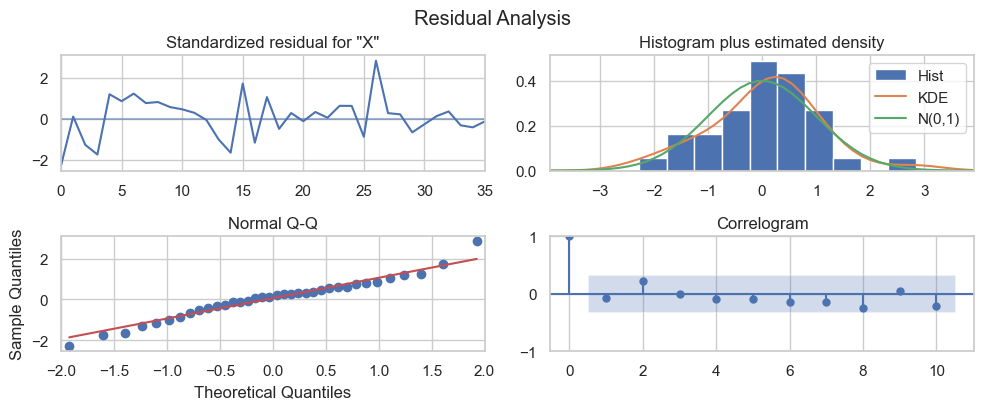

In [6]:
model = params.to_model(endog=df["X_t"])
model_fit = model.fit(disp=0)
model_fit.summary()

fig = plt.figure(figsize=(10, 4))
model_fit.plot_diagnostics(fig=fig)
plt.tight_layout()

residuals = model_fit.resid
print(np.mean(residuals))

plt.suptitle("Residual Analysis", y=1.02)
plt.savefig(OUTPUT_PATH / "2_residual_analysis.png", dpi=EXPORT_DPI, bbox_inches="tight")

In [7]:
df

,year,month,power,Y_t,X_t
0,2008,1,66,66,-1.530345
1,2008,2,184,184,-0.505064
2,2008,3,114,114,-0.983802
3,2008,4,71,71,-1.457320
4,2008,5,373,373,0.201578
5,2008,6,562,562,0.611502
6,2008,7,824,824,0.994171
7,2008,8,708,708,0.842444
8,2008,9,680,680,0.802093
9,2008,10,551,551,0.591735


## 2.2 - Forecasting

In [8]:
model_fit.forecast(steps=12)

df_forecast = pd.DataFrame({"X_t": model_fit.forecast(steps=12)})
df_forecast["Y_t"] = np.exp(df_forecast["X_t"] + mu)
df_forecast["Type"] = "Forecast"
df_forecast["year"] = 2011
df_forecast["month"] = np.arange(1, 13)
df["Type"] = "Observed"

df = pd.concat([df, df_forecast])
df["time"] = pd.to_datetime(df[["year", "month"]].assign(day=1))

df_present = df.query("Type == 'Forecast'")[["time", "Y_t", "X_t"]].copy()
df_present.rename(columns={
    "time": "Time",
    "Y_t": "Y_t (Power) [MWh]",
}, inplace=True)

df_present.to_csv(OUTPUT_PATH / "2_2.csv", index=False)

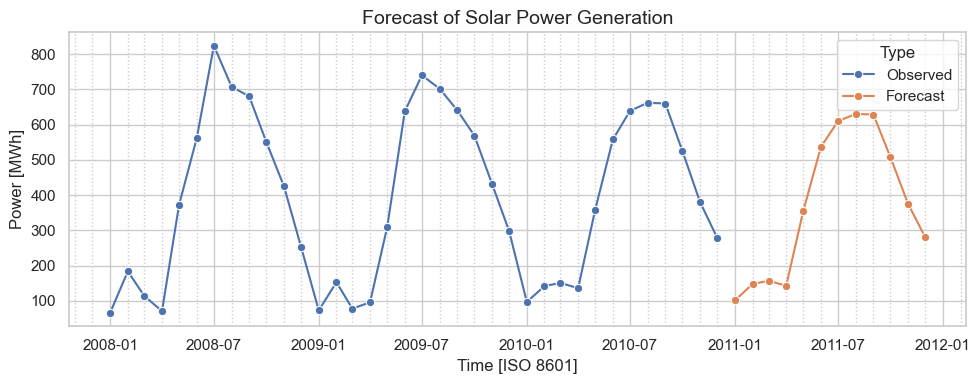

In [37]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(df, x="time", y="Y_t", hue="Type", ax=ax, marker="o")

plt.title("Forecast of Solar Power Generation", fontsize=14)
plt.xlabel("Time [ISO 8601]")
plt.ylabel("Power [MWh]")
plt.tight_layout()

ax.get_xaxis().set_minor_locator(mpl.dates.MonthLocator())
plt.grid(which="minor", linestyle=":")
plt.savefig(
    OUTPUT_PATH / "2_2_forecast.png",
    dpi=EXPORT_DPI,
    bbox_inches="tight",
)

# df
